# Задача: Многоклассовая классификация и множественная классификация/регрессия. Лямин Владимир Андреевич. Группа 22.М05

Задача
1. Изучите возможности sklearn для решения задач Multiclass classification, Multilabel classification и Multioutput Regression. Основные компоненты библиотеки указаны на рисунке ниже. multi_org_chart

2. Найдите данные, на которых можно решить задачу Multiclass classification (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.

3. Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.

4. При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).

5. Используя стратегии OneVsRest, OneVsOne и OutputCode решите задачу Multiclass classification для каждого из пройденных базового алгоритма классификации (logistic regression, svm, knn, naive bayes, decision tree). При обучении использовать подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания.

6. Замерить время обучения каждой модели для каждой стратегии.

7. Для оценки качества моделей используйте метрику AUC-ROC.

8. Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.

Рассмотрим датасет по стоимости жилья, затем сделаем из него подходящий датасет для задачи по многоклассовой классификации по данному руководству(https://medium.com/dataman-in-ai/a-wide-choice-for-modeling-multi-class-classifications-d97073ff4ec8).

Описание датасета:
1. MedInc: средний доход в квартале
2. house: средний возраст домов в квартале
3. AveRooms: среднее количество комнат на дом
4. AveBedrms: среднее количество спален на дом
5. Population: популяция квартала
6. AveOccup: среднее количество жителей дома
7. Latitude: широта квартала
8. Longitude: долгота квартала

Необходимо решить задачу классификации и научиться предсказывать целовой признак target. Среднюю стоимость дома в квартале.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [2]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target
df = X.copy()
df['target'] = y * 100000 # The raw value is in 100,000.
X_features = cal_housing.feature_names
print("X features=", X_features)

X features= ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0


Проверяем общее количество пропущенных значений.



In [4]:
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

Как видно, пропущенных значений нет

Преобразуем данные, как показано в инструкции. (https://medium.com/dataman-in-ai/a-wide-choice-for-modeling-multi-class-classifications-d97073ff4ec8)

In [5]:
def val_target(y):
    if y<=100000:
        return 0
    elif y<=160000:
        return 1
    elif y<=240000:
        return 2
    else:
        return 3
    
df['target_class'] = df['target'].apply(val_target)

In [6]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,target_class
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0,3
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0,3
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0,3
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0,3
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0,3


Всего у нас получилось 4 класса:
1. ≤100k
2. 100k~160k
3. 160k~240k
4. 240k+

## Разведочный анализ (EDA)

Посмортим какие значения принимает целевой признак

In [7]:
df.target_class.value_counts()

3    6310
2    5791
1    4881
0    3658
Name: target_class, dtype: int64

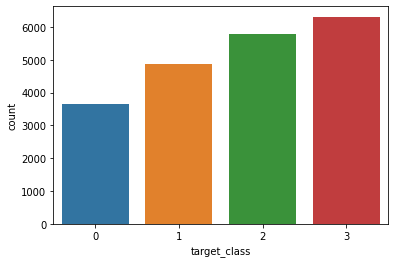

In [8]:
sns.countplot(x="target_class", data=df)
plt.show()


Можно заметить, что получившиеся классы сравнимы

## Певичный анализ признаков

### Количесвенный признак MedInc

Посмотрим какие значения принмиает данный признак



In [9]:
df['MedInc'].describe()


count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: MedInc, dtype: float64

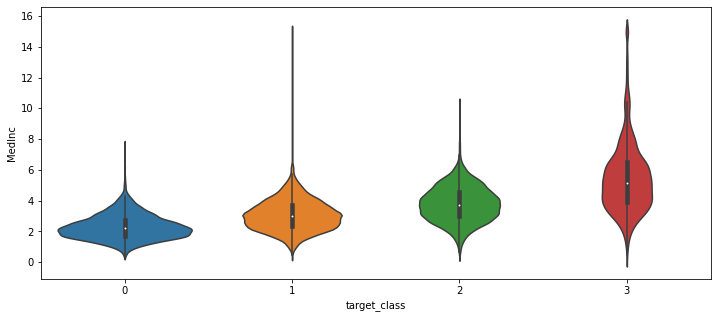

In [10]:
sns.violinplot(data=df,x="target_class", y='MedInc', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()


Можно заметить, что чем выше доход житеелей квартала, тем более высокая стоимость домов

### Количесвенный признак HouseAge

In [11]:
df['HouseAge'].describe()

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: HouseAge, dtype: float64

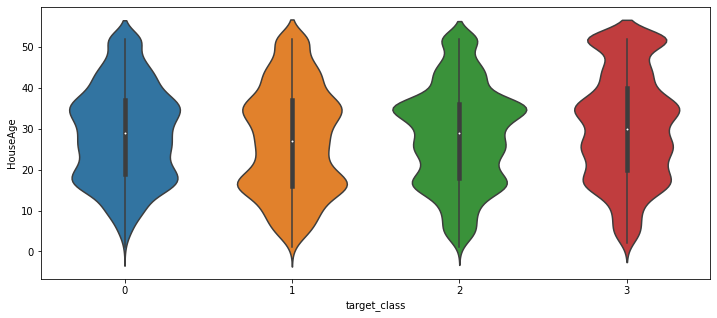

In [12]:
sns.violinplot(data=df,x="target_class", y='HouseAge', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()


Можно заметить, что возраст дома на стоимость влияет слабо

### Количесвенный признак AveRooms

In [13]:
df['AveRooms'].describe()

count    20640.000000
mean         5.429000
std          2.474173
min          0.846154
25%          4.440716
50%          5.229129
75%          6.052381
max        141.909091
Name: AveRooms, dtype: float64

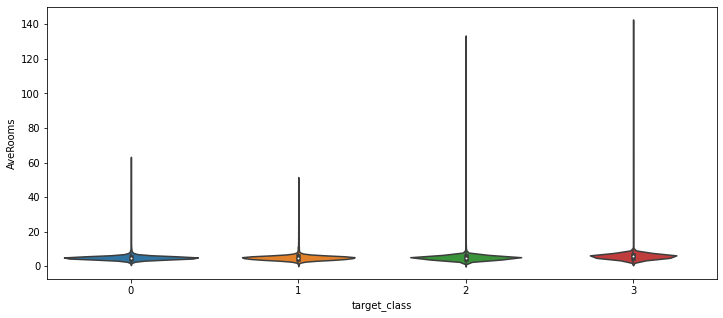

In [14]:
sns.violinplot(data=df,x="target_class", y='AveRooms', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()


Тут можно заметить, что при увеличении комнат стоимость дома увеличивается.

### Количесвенный признак Population

In [15]:
df['Population'].describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: Population, dtype: float64

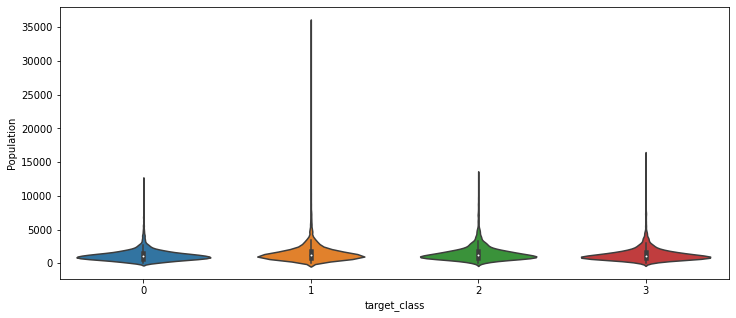

In [16]:
sns.violinplot(data=df,x="target_class", y='Population', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()


Тут можно заметить, что наиболее дорогие и дешевые дома располагаются в районах с маленькой численность населения. 

### Количесвенный признак AveOccup

In [17]:
df['AveOccup'].describe()

count    20640.000000
mean         3.070655
std         10.386050
min          0.692308
25%          2.429741
50%          2.818116
75%          3.282261
max       1243.333333
Name: AveOccup, dtype: float64

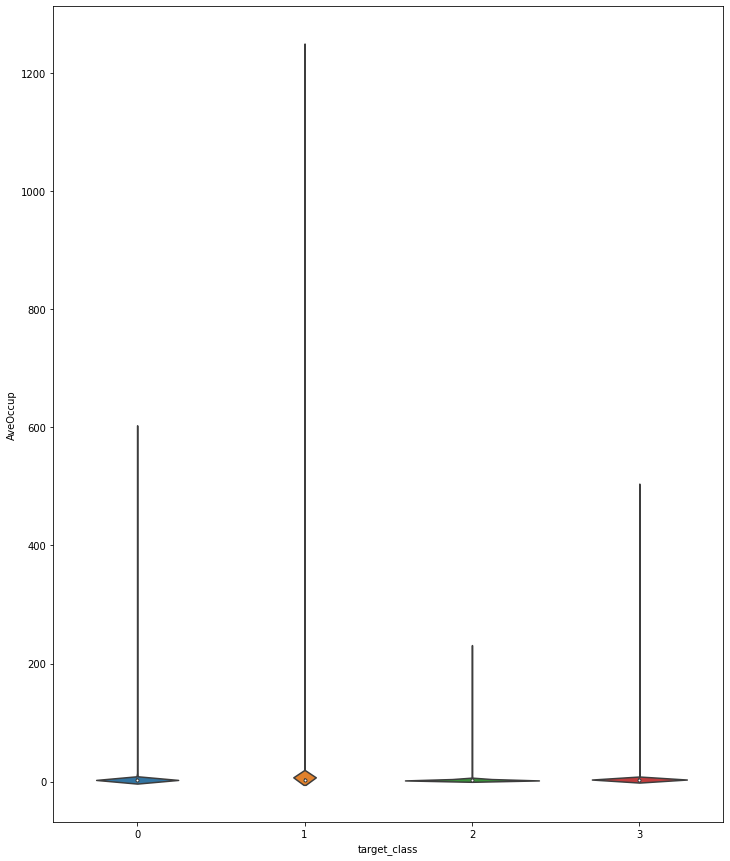

In [18]:
sns.violinplot(data=df,x="target_class", y='AveOccup', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 15)
plt.show()

Можно заметить, что чем дороже дом, тем меньше средняя численость его жителей

### Количесвенный признак Latitude

In [19]:
df['Latitude'].describe()

count    20640.000000
mean        35.631861
std          2.135952
min         32.540000
25%         33.930000
50%         34.260000
75%         37.710000
max         41.950000
Name: Latitude, dtype: float64

## Feature Engineering

Заменем количесвенные вещественные признаки категориальными. Будем распределять по классам с примерно одинаковой численностью

In [20]:
def val_target(y):
    if y<=1:
        return 0
    elif y<=2:
        return 1
    elif y<=3:
        return 2
    else:
        return 3
    
df['MedInc_class'] = df['MedInc'].apply(val_target)

In [21]:
def val_target(y):
    if y<=2:
        return 0
    elif y<=3:
        return 1
    elif y<=4:
        return 2
    else:
        return 3
    
df['AveRooms_class'] = df['AveRooms'].apply(val_target)

In [22]:
def val_target(y):
    if y<=1:
        return 0
    elif y<=2:
        return 1
    else:
        return 2
    
df['AveBedrms_class'] = df['AveBedrms'].apply(val_target)

In [23]:
def val_target(y):
    if y<=2:
        return 0
    elif y<=3:
        return 1
    elif y<=4:
        return 2
    else:
        return 3
    
df['AveOccup_class'] = df['AveOccup'].apply(val_target)

In [24]:
def val_target(y):
    if y<=33:
        return 0
    elif y<=34:
        return 1
    elif y<=37:
        return 2
    else:
        return 3
    
df['Latitude_class'] = df['Latitude'].apply(val_target)

## Удаление ненужных признаков

Так как мы ввели новый признак target_class, то можно удалить признак target

In [25]:
df.drop(['target'], axis=1, inplace=True)

Также удаляем вещественные признаки, которые мы заменили категориальными

In [26]:
# Удаляем количественные признаки, которые преобразовали в категориальные.
df.drop(['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude'], axis = 1, inplace = True)

## Посмотрим корреляцию данных


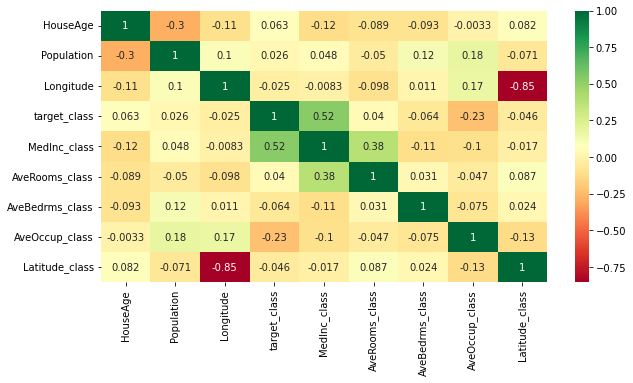

In [27]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Можно заметить, что Latitude и Longitude сильно коррелируют. Поэтому можно удалить одну из них.

In [28]:
df.drop(['Longitude'], axis=1, inplace=True)

## Разбиение данных

Разобъем данные на тестовую выборку и обучающую

In [29]:
from sklearn.model_selection import train_test_split

y = df["target_class"]
X = df.drop(columns=["target_class"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Проверим, что мы получили то, что хотели

In [30]:
df.head()

,HouseAge,Population,target_class,MedInc_class,AveRooms_class,AveBedrms_class,AveOccup_class,Latitude_class
0,41.0,322.0,3,3,3,1,1,3
1,21.0,2401.0,3,3,3,0,1,3
2,52.0,496.0,3,3,3,1,1,3
3,52.0,558.0,3,3,3,1,1,3
4,52.0,565.0,3,3,3,1,1,3


Далее будем для кадого алгоритма строить 3 стратегии: OneVsRest, OneVsOne и OutputCode

## Logistic Regression

Импортируем библиотеки и подготавливаем параметры

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier
import time
from sklearn.metrics import accuracy_score

classifier_lr = LogisticRegression()
pipeline = Pipeline([('scalar', StandardScaler()), ('model', LogisticRegression(random_state=40))])


parameters = { 'model__C' : [1,10,100,1000,10000],
               'model__fit_intercept' : [True],
               'model__multi_class' : ['auto'],
               'model__tol' : [0.0001],
               'model__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'model__n_jobs' : [-1],
               'model__max_iter' : [5000]
}

fold_number = 3

grid = GridSearchCV(pipeline, parameters, scoring = 'roc_auc', cv = fold_number)

### OneVsRest

Проведем обучение по стратегии OneVsRest

In [32]:
classifier = OneVsRestClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

lr_oneVsRest_time = end_time - start_time 
print(f'Training time: {lr_oneVsRest_time}')

y_train_pred = classifier.predict(X_train)
lr_oneVsRest_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {lr_oneVsRest_train_accuracy}')

y_test_pred = classifier.predict(X_test)
lr_oneVsRest_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {lr_oneVsRest_test_accuracy}')

Training time: 24.751904726028442
Train Accuracy: 0.4804817275747508
Test Accuracy: 0.4838501291989664


### OneVsOne

In [33]:
classifier = OneVsOneClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

lr_oneVsOne_time = end_time - start_time 
print(f'Training time: {lr_oneVsOne_time}')

y_train_pred = classifier.predict(X_train)
lr_oneVsOne_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {lr_oneVsOne_train_accuracy}')

y_test_pred = classifier.predict(X_test)
lr_oneVsOne_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {lr_oneVsOne_test_accuracy}')

Training time: 10.224495649337769
Train Accuracy: 0.4831810631229236
Test Accuracy: 0.4904715762273902


### OutputCode

In [35]:
classifier = OutputCodeClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

lr_outputCode_time = end_time - start_time 
print(f'Training time: {lr_outputCode_time}')

y_train_pred = classifier.predict(X_train)
lr_outputCode_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {lr_outputCode_train_accuracy}')

y_test_pred = classifier.predict(X_test)
lr_outputCode_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {lr_outputCode_test_accuracy}')

Training time: 25.485751628875732
Train Accuracy: 0.4668466223698782
Test Accuracy: 0.47416020671834624


## SVM

In [39]:
from sklearn.svm import SVC

hyper_params_dict = { 
    'model__kernel' : ['sigmoid'],
    'model__C' : [1,10,100],
    'model__random_state' : [40]
}

fold_number = 3

pipeline = Pipeline([('scalar', StandardScaler()), ('model', SVC())])

grid = GridSearchCV(pipeline, hyper_params_dict, scoring = 'roc_auc', cv = fold_number)

### OneVsRest

In [40]:
classifier = OneVsRestClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()
print(1)

svm_oneVsRest_time = end_time - start_time 
print(f'Training time: {svm_oneVsRest_time}')

y_train_pred = classifier.predict(X_train)
svm_oneVsRest_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {svm_oneVsRest_train_accuracy}')

y_test_pred = classifier.predict(X_test)
svm_oneVsRest_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {svm_oneVsRest_test_accuracy}')

1
Training time: 144.32786679267883
Train Accuracy: 0.3596345514950166
Test Accuracy: 0.36611757105943155


### OneVsOne

In [41]:
classifier = OneVsOneClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

svm_oneVsOne_time = end_time - start_time 
print(f'Training time: {svm_oneVsOne_time}')

y_train_pred = classifier.predict(X_train)
svm_oneVsOne_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {svm_oneVsOne_train_accuracy}')

y_test_pred = classifier.predict(X_test)
svm_oneVsOne_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {svm_oneVsOne_test_accuracy}')

Training time: 50.14580535888672
Train Accuracy: 0.36745570321151716
Test Accuracy: 0.36983204134366926


### OutputCode

In [42]:
classifier = OutputCodeClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

svm_outputCode_time = end_time - start_time 
print(f'Training time: {svm_outputCode_time}')

y_train_pred = classifier.predict(X_train)
svm_outputCode_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {svm_outputCode_train_accuracy}')

y_test_pred = classifier.predict(X_test)
svm_outputCode_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {svm_outputCode_test_accuracy}')

Training time: 242.5559582710266
Train Accuracy: 0.3290420819490587
Test Accuracy: 0.33527131782945735


### KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

hyper_params_dict = { 
    'model__n_neighbors': [1, 2, 3, 4, 5],
    'model__leaf_size': [20, 40, 60, 80],
    'model__weights': ['distance', 'uniform'],
    'model__n_jobs': [-1]
}

fold_number = 3

pipeline = Pipeline([('scalar', StandardScaler()), ('model', KNeighborsClassifier())])

grid = GridSearchCV(pipeline, hyper_params_dict, scoring = 'roc_auc', cv = fold_number)

### OneUsRest

In [44]:
classifier = OneVsRestClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

knn_oneVsRest_time = end_time - start_time 
print(f'Training time: {knn_oneVsRest_time}')

y_train_pred = classifier.predict(X_train)
knn_oneVsRest_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {knn_oneVsRest_train_accuracy}')

y_test_pred = classifier.predict(X_test)
knn_oneVsRest_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {knn_oneVsRest_test_accuracy}')

Training time: 75.72481393814087
Train Accuracy: 0.6319905869324474
Test Accuracy: 0.4896640826873385


### OneUsOne

In [45]:
classifier = OneVsOneClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

knn_oneVsOne_time = end_time - start_time 
print(f'Training time: {knn_oneVsOne_time}')

y_train_pred = classifier.predict(X_train)
knn_oneVsOne_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {knn_oneVsOne_train_accuracy}')

y_test_pred = classifier.predict(X_test)
knn_oneVsOne_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {knn_oneVsOne_test_accuracy}')

Training time: 41.90096092224121
Train Accuracy: 0.6265919158361019
Test Accuracy: 0.49434754521963825


### OutputCode

In [46]:
classifier = OutputCodeClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

knn_outputCode_time = end_time - start_time 
print(f'Training time: {knn_outputCode_time}')

y_train_pred = classifier.predict(X_train)
knn_outputCode_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {knn_outputCode_train_accuracy}')

y_test_pred = classifier.predict(X_test)
knn_outputCode_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {knn_outputCode_test_accuracy}')

Training time: 102.81742358207703
Train Accuracy: 0.6191860465116279
Test Accuracy: 0.4672157622739018


## Naive Bayes


In [47]:
from sklearn.naive_bayes import GaussianNB


parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
grid = GridSearchCV(GaussianNB(), parameters, scoring='roc_auc', cv = 3).fit(X_train, y_train.ravel())

### OneUsRest

In [48]:
classifier = OneVsRestClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

nb_oneVsRest_time = end_time - start_time 
print(f'Training time: {nb_oneVsRest_time}')

y_train_pred = classifier.predict(X_train)
nb_oneVsRest_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {nb_oneVsRest_train_accuracy}')

y_test_pred = classifier.predict(X_test)
nb_oneVsRest_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {nb_oneVsRest_test_accuracy}')

Training time: 12.869529962539673
Train Accuracy: 0.46677740863787376
Test Accuracy: 0.4555878552971576


### OneUsOne

In [51]:
classifier = OneVsOneClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

nb_oneVsOne_time = end_time - start_time 
print(f'Training time: {nb_oneVsOne_time}')

y_train_pred = classifier.predict(X_train)
nb_oneVsOne_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {nb_oneVsOne_train_accuracy}')

y_test_pred = classifier.predict(X_test)
nb_oneVsOne_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {nb_oneVsOne_test_accuracy}')

Training time: 8.337671756744385
Train Accuracy: 0.46124031007751937
Test Accuracy: 0.4583333333333333


### OutputCode

In [52]:
classifier = OutputCodeClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

nb_outputCode_time = end_time - start_time 
print(f'Training time: {nb_outputCode_time}')

y_train_pred = classifier.predict(X_train)
nb_outputCode_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {nb_outputCode_train_accuracy}')

y_test_pred = classifier.predict(X_test)
nb_outputCode_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {nb_outputCode_test_accuracy}')

Training time: 8.540462732315063
Train Accuracy: 0.3966638981173865
Test Accuracy: 0.4055232558139535


## Decision Tree


In [53]:
from sklearn.tree import DecisionTreeClassifier

hyper_params_dict = {
     "model__max_depth": np.arange(1,21),
     "model__criterion": ["gini"],
}

fold_number = 3

pipeline = Pipeline([('scalar', StandardScaler()), ('model', DecisionTreeClassifier())])

grid = GridSearchCV(pipeline, hyper_params_dict, scoring = 'roc_auc', cv = fold_number)

### OneUsRest

In [54]:
classifier = OneVsRestClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

dt_oneVsRest_time = end_time - start_time 
print(f'Training time: {dt_oneVsRest_time}')

y_train_pred = classifier.predict(X_train)
dt_oneVsRest_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {dt_oneVsRest_train_accuracy}')

y_test_pred = classifier.predict(X_test)
dt_oneVsRest_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {dt_oneVsRest_test_accuracy}')

Training time: 6.373146295547485
Train Accuracy: 0.5464424141749723
Test Accuracy: 0.5179263565891473


### OneUsOne


In [55]:
classifier = OneVsOneClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

dt_oneVsOne_time = end_time - start_time 
print(f'Training time: {dt_oneVsOne_time}')

y_train_pred = classifier.predict(X_train)
dt_oneVsOne_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {dt_oneVsOne_train_accuracy}')

y_test_pred = classifier.predict(X_test)
dt_oneVsOne_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {dt_oneVsOne_test_accuracy}')

Training time: 4.87842059135437
Train Accuracy: 0.528516057585825
Test Accuracy: 0.5142118863049095


### OutputCode

In [57]:
classifier = OutputCodeClassifier(grid)

start_time = time.time()
classifier.fit(X_train, y_train.ravel())
end_time = time.time()

dt_outputCode_time = end_time - start_time 
print(f'Training time: {dt_outputCode_time}')

y_train_pred = classifier.predict(X_train)
dt_outputCode_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {dt_outputCode_train_accuracy}')

y_test_pred = classifier.predict(X_test)
dt_outputCode_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {dt_outputCode_test_accuracy}')

Training time: 8.004969835281372
Train Accuracy: 0.5316306755260244
Test Accuracy: 0.5104974160206718


## Выводы

### Промежуточные выводы о точности методов и стратегий

Сделаем таблицу с данными

In [58]:
table = {
    'stratagies\methods': ['OneVsRest', 'OneVsOne', 'OutputCode'],
    'lr train':[lr_oneVsRest_train_accuracy, lr_oneVsOne_train_accuracy, lr_outputCode_train_accuracy],
    'lr test': [lr_oneVsRest_test_accuracy, lr_oneVsOne_test_accuracy, lr_outputCode_test_accuracy],
    'svm train': [svm_oneVsRest_train_accuracy, svm_oneVsOne_train_accuracy, svm_outputCode_train_accuracy],
    'svm test': [svm_oneVsRest_test_accuracy, svm_oneVsOne_test_accuracy, svm_outputCode_test_accuracy],
    'knn train':[knn_oneVsRest_train_accuracy, knn_oneVsOne_train_accuracy, knn_outputCode_train_accuracy],
    'knn test': [knn_oneVsRest_test_accuracy,knn_oneVsOne_test_accuracy, knn_outputCode_test_accuracy],
    'nb train': [nb_oneVsRest_train_accuracy, nb_oneVsOne_train_accuracy, nb_outputCode_train_accuracy],
    'nb test': [nb_oneVsRest_test_accuracy, nb_oneVsOne_test_accuracy, nb_outputCode_test_accuracy],
    'dt train':[dt_oneVsRest_train_accuracy, dt_oneVsOne_train_accuracy, dt_outputCode_train_accuracy],
    'dt test': [dt_oneVsRest_test_accuracy, dt_oneVsOne_test_accuracy, dt_outputCode_test_accuracy],
}

pd.DataFrame(data=table)

,stratagies\methods,lr train,lr test,svm train,svm test,knn train,knn test,nb train,nb test,dt train,dt test
0,OneVsRest,0.480482,0.483850,0.359635,0.366118,0.631991,0.489664,0.466777,0.455588,0.546442,0.517926
1,OneVsOne,0.483181,0.490472,0.367456,0.369832,0.626592,0.494348,0.461240,0.458333,0.528516,0.514212
2,OutputCode,0.466847,0.474160,0.329042,0.335271,0.619186,0.467216,0.396664,0.405523,0.531631,0.510497


Как видно по точности почти везде выигрывает стратегия OneVsOne, хотя на некоторых измерениях ее опережает OneVsRest. Худшая стратегия оказалась OutputCode. Из методов можно выделить decision tree, который дал лучший результат на тестовой выборке. SVM же оказалася наиболее худший метод по точности.

### Промежуточные выводы о продолжительности обучения методов и стратегий

In [60]:
table = {
    'stratagies\methods': ['OneVsRest', 'OneVsOne', 'OutputCode'],
    'lr train':[lr_oneVsRest_time, lr_oneVsOne_time, lr_outputCode_time],
    'svm train': [svm_oneVsRest_time, svm_oneVsOne_time, svm_outputCode_time],
    'knn train':[knn_oneVsRest_time, knn_oneVsOne_time, knn_outputCode_time],
    'nb train': [nb_oneVsRest_time, nb_oneVsOne_time, nb_outputCode_time],
    'dt train':[dt_oneVsRest_time, dt_oneVsOne_time, dt_outputCode_time],
}

pd.DataFrame(data=table)

,stratagies\methods,lr train,svm train,knn train,nb train,dt train
0,OneVsRest,24.751905,144.327867,75.724814,12.869530,6.373146
1,OneVsOne,10.224496,50.145805,41.900961,8.337672,4.878421
2,OutputCode,25.485752,242.555958,102.817424,8.540463,8.004970


Здесь напрашивается вывод, что метод SVM дает плохой результат по продолжительности обучения. А вот метод решающих деревьев дает очень положительный результат. Также наиболее быстрое обучение происходило при стратегии OneVsOne

### Общие выводы

Если суммировать оба параметра, то напрашивается вывод, что наиболее лучшая стратегия -- это  OneVsOne. Она дает наиболее лучший результат в наиболее сжатые сроки. Также лучше использовать метод решающих деревьев или KNN